In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools.coco import COCO

## COCOから入力画像と出力ヒートマップのデータを作成

- 入力画像: (None, 480, 480, 3)
- 出力ヒートマップ: (None, 60, 60, 1)
- 出力ヒートマップのチャネルは鼻パーツのヒートマップを意味する

keypointsは[x, y, visible]の3つ組のリスト。鼻、左目、右目、左耳、右耳、左肩、右肩、左ひじ、右ひじ、左手、右手、左脚、右脚、左膝、右膝、左足、右足の順で17個入っている。3x17=51。

In [3]:
ann_file = './data/coco/annotations/person_keypoints_train2014.json'
coco = COCO(ann_file)

loading annotations into memory...
Done (t=8.88s)
creating index...
index created!


In [4]:
# personカテゴリが存在する画像のIDを抽出
img_ids = coco.getImgIds(catIds=coco.getCatIds(catNms=['person']))
img_ids = sorted(img_ids)

# 上記の画像情報を取得
img_info = coco.loadImgs(img_ids)
print(len(img_info))

# 元画像の width と height が含まれるためリサイズ後のアノテーション相対座標は計算できる
print(img_info[0])

45174
{'id': 36, 'file_name': 'COCO_train2014_000000000036.jpg', 'license': 3, 'width': 481, 'flickr_url': 'http://farm8.staticflickr.com/7216/7200825264_af0f941e1a_z.jpg', 'height': 640, 'date_captured': '2013-11-18 06:56:10', 'coco_url': 'http://mscoco.org/images/36'}


In [8]:
# CNNへの入力画像サイズ
IMG_WIDTH, IMG_HEIGHT = 368, 368
# CNNの出力ヒートマップサイズ
FM_WIDTH, FM_HEIGHT = 46, 46
# パーツのガウシアンの幅
SIGMA = 3

def load_image(img_paht):
    img = Image.open(img_path)
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    img = np.array(img)
    # 1チャンネル画像は除く
    if len(img.shape) == 2:
        return None
    return img

def get_parts_annotation(info):
    persons = []

    width, height = info['width'], info['height']
    ann_ids = coco.getAnnIds(imgIds=info['id'])
    
    # 各人物のアノテーションリストを取得
    anns = coco.loadAnns(ann_ids)

    # 各人物のアノテーションから必要な情報を抽出
    for i in range(len(anns)):
        # キーポイントが1つもない人は無視
        if anns[i]['num_keypoints'] == 0: continue

        # 鼻のキーポイント (x,y,v) がない人は無視
        nose_keypoints = anns[i]['keypoints'][0:3]
        if nose_keypoints[2] != 2: continue

        # 0-1の相対座標に変換してから保存
        xs = nose_keypoints[0] / width
        ys = nose_keypoints[1] / height
        persons.append((xs, ys))

    return persons

def plot_persons(img, persons):
    plt.figure()
    
    # リサイズした画像を描画
    plt.imshow(img)
    plt.xlim((0, IMG_WIDTH))
    plt.ylim((IMG_HEIGHT, 0))
    plt.axis('off')

    # 鼻パーツを描画
    # 相対座標なのでピクセルに戻す
    for p in persons:
        xs, ys = p
        plt.plot([xs * IMG_WIDTH], [ys * IMG_HEIGHT], marker='o', markersize=3, color='red')

def plot_heatmap(img, hm):
    """
    img
    hm: (height, width, channel)
    """
    from scipy.misc import imresize
    plt.figure()
    img = imresize(img, (FM_WIDTH, FM_HEIGHT))
    plt.imshow(img)
    plt.imshow(hm[:, :, 0], alpha=0.4)

def create_heatmap(persons, width, height, sigma):
    """
    persons: relative keypoints list
    width: heatmap width
    height: heatmap height
    sigma
    """
    # 今回はパーツは1つなのでSは3次元でOK
    S = np.zeros(shape=(len(persons), height, width))
    
    for k in range(len(persons)):  # 各人について処理
        x = np.array(persons[k])
        assert len(x) == 2

        # relative => pixel
        x[0] = width * x[0]
        x[1] = height * x[1]
        
        for i in range(height):
            for j in range(width):
                p = np.array([j, i])
                d = np.linalg.norm(p - x, 2) ** 2
                S[k, i, j] = np.exp(- d / (sigma * sigma))

    # 人物単位でmaxをとる
    hm = S.max(axis=0)
    
    # チャネルを追加
    # 鼻のみなので1チャンネル
    hm = np.expand_dims(hm, axis=2)

    return hm

In [9]:
a = np.array([[[1, 2], [3, 4]], [[5, 1], [8, 2]]])
print(a[0])
print(a[1])
print(a.max(axis=0))

[[1 2]
 [3 4]]
[[5 1]
 [8 2]]
[[5 2]
 [8 4]]


(4, 368, 368, 3)
(4, 46, 46, 1)
['COCO_train2014_000000000036.jpg' 'COCO_train2014_000000000049.jpg'
 'COCO_train2014_000000000110.jpg' 'COCO_train2014_000000000113.jpg']


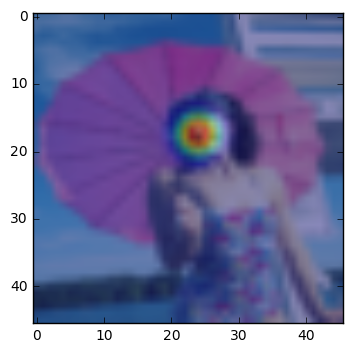

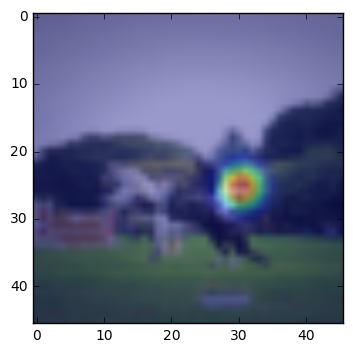

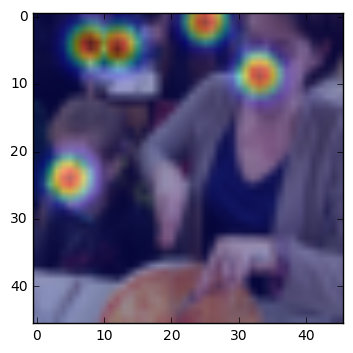

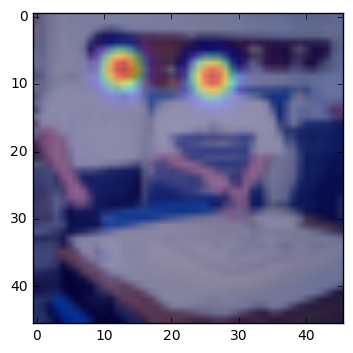

In [10]:
# 画像をデータ化して保存
input_img_data = []  # (batch, height, width, channel)
heatmaps = []        # (batch, height, width, channel=1)
filenames = []

for info in img_info[:10]:  # 各画像についてループ
    # パーツ情報（鼻の相対座標）を取得
    persons = get_parts_annotation(info)
    # パーツが1つもない画像は無視
    if persons == []: continue

    # 画像をロードして配列可して保存
    img_path = os.path.join('data/coco/train2014', info['file_name'])
    img = load_image(img_path)
    if img is None: continue
    input_img_data.append(img)
    filenames.append(info['file_name'])

    # テスト用のプロット
#     plot_persons(img, persons)
    
    # ヒートマップを作成
    # パーツの座標はCNNの出力するヒートマップサイズに合わせた座標に変換する
    hm = create_heatmap(persons, FM_WIDTH, FM_HEIGHT, SIGMA)
    heatmaps.append(hm)

    # 元画像を縮小した画像に重ね合わせる
    plot_heatmap(img, hm)

input_img_data = np.array(input_img_data)
heatmaps = np.array(heatmaps)
filenames = np.array(filenames)

print(input_img_data.shape)
print(heatmaps.shape)
print(filenames)

np.save('input_img_data.npy', input_img_data)
np.save('heatmaps.npy', heatmaps)
np.save('filenames.npy', filenames)

## モデル構築

- Realtime Multi-Person 2D Pose Estimation using Part Affinity Fields
- VGG19 + Stage1のPart Confidence Mapsのみ
- 入力の画像の1/8サイズのヒートマップを出力する

In [144]:
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Reshape
from keras.applications.vgg19 import VGG19

IMG_WIDTH, IMG_HEIGHT = 368, 368

vgg19 = VGG19(include_top=False, weights='imagenet',
              input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

for i in range(8):
    vgg19.layers.pop()
vgg19.outputs = [vgg19.layers[-1].output]

m = Sequential()
m.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv3_CPM',
             input_shape=vgg19.layers[-1].output_shape[1:]))
m.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv4_CPM'))

# stage1 part confidence map
m.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block5_conv1_CMP_L2'))
m.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block5_conv2_CMP_L2'))
m.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block5_conv3_CMP_L2'))
m.add(Conv2D(512, (1, 1), activation='relu', padding='same', name='block5_conv4_CMP_L2'))
m.add(Conv2D(1,   (1, 1), activation='relu', padding='same', name='block5_conv5_CMP_L2'))
m.add(Reshape((46 * 46 * 1, )))

# PoseNet
model = Model(inputs=vgg19.inputs, outputs=m(vgg19.outputs))

In [145]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 368, 368, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 368, 368, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 368, 368, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 184, 184, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 184, 184, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 184, 184, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 92, 92, 128)       0         
__________

## 訓練

In [157]:
input_img_data = np.load('input_img_data.npy')

In [158]:
input_img_data.shape

(4, 368, 368, 3)